# Boiler Plate for productionising Data Science

I am going to show you how to publish the following model in the cloud, at [pythonanywhere.com](https://www.pythonanywhere.com). Too often data scientists are accused of not being able to productionise their work. My aim for this tutorial is to help you become end to end, from inception to production!

First, semantics:

Disclaimer

This notebook and ensuing API or endpoint deployment on automatic COVID-19 detection is for educational purposes only. It is not meant to be a reliable, highly accurate COVID-19 diagnosis system, nor has it been professionally or academically vetted.



Now I also want to share that this notebook is also UNASHAMEDLY based on the following [great article by Adrian Rosebrock](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/). I forked an implementation of this great article [here](https://www.kaggle.com/bachrr/detecting-covid-19-in-x-ray-images-with-tensorflow).

Once I had run the model below, I uploaded it to pythonanywhere.com and promptly deployed it and front ended it using FLASK.

Without further ado, here is the endpoint for your enjoyment:
[Covid-19 predictor API](http://coviddetector.pythonanywhere.com)

It is easy to open a free account with pythonanywhere and publish your models for public consumption. Just ensure that you do so responsibly and professionally. That's my advice anyway.

**STEP BY STEP INSTRUCTIONS FOR DEPLOYING YOUR OWN API:**

Step 1:

Run the code below to generate the model file: covid_model.h5

Step 2:

Open up a free account on pythonanywhere.com, choose FLASK and python version 3.6, then open web tab(on the right) and add new web application(top left), accept defaults.

Step 3:

Drop the covid_model.h5 and flask_app.py files in the mysite folder. The flask_app.py file resides in the pythonanywherecode data folder in this book.

Step 4:

Create a templates and static folders in the mysite directory on pythonanywhere.com.

Step 5:

drop the html files in the templates folder, and voila, try out your new web app!

Step 6: pls upvote my book if you found this useful! Lets help each other democratize deploying ML, Deep Learning and AI!

Pls comment at the bottom if you see that you can improve the steps above! Also comment your web app if you were successful! I want to hear about it!


In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=465320cc5c5dc590376851763fa0acad7aa4e69f2c0e0a6b88617c6c2dcfc2a7
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [3]:
dataset_path = './dataset'

## Build Dataset

In [4]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal

### Covid xray dataset

In [5]:
samples = 25

In [6]:
covid_dataset_path = '../input/covid-chest-xray'

In [7]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Build normal xray dataset

In [8]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [9]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

Helper function to plot the images in a grid

In [10]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [11]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

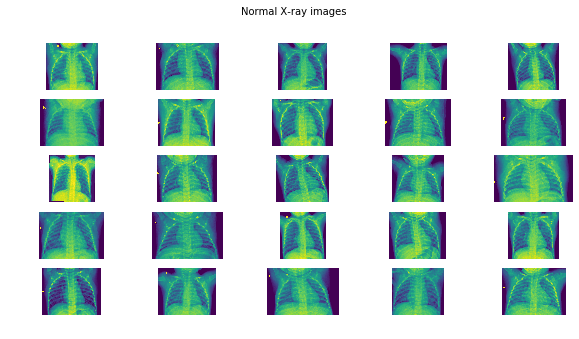

In [12]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

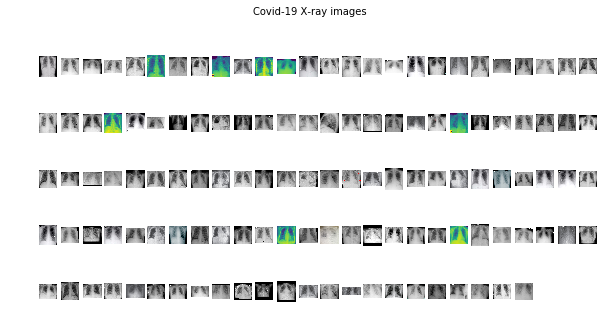

In [13]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [14]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [15]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [16]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

## Model

In [17]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 5s 0us/step


### Training

In [18]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Train for 15 steps, validate on 31 samples
Epoch 1/10
15/15 [==============================] - 36s 2s/step - loss: 0.5381 - accuracy: 0.7417 - val_loss: 0.3778 - val_accuracy: 0.8333
Epoch 2/10
15/15 [==============================] - 32s 2s/step - loss: 0.4485 - accuracy: 0.8496 - val_loss: 0.3284 - val_accuracy: 0.8333
Epoch 3/10
15/15 [==============================] - 33s 2s/step - loss: 0.4106 - accuracy: 0.8407 - val_loss: 0.2940 - val_accuracy: 0.8333
Epoch 4/10
15/15 [==============================] - 32s 2s/step - loss: 0.3749 - accuracy: 0.8496 - val_loss: 0.2736 - val_accuracy: 0.8333
Epoch 5/10
15/15 [==============================] - 33s 2s/step - loss: 0.3084 - accuracy: 0.8761 - val_loss: 0.2421 - val_accuracy: 0.8333
Epoch 6/10
15/15 [==============================] - 33s 2s/step - loss: 0.2699 - accuracy: 0.8584 - val_loss: 0.2257 - val_accuracy: 0.8333
Epoch 7/10
15/15 [==============================] - 33s 2s/step - l

### Plot trining metrics

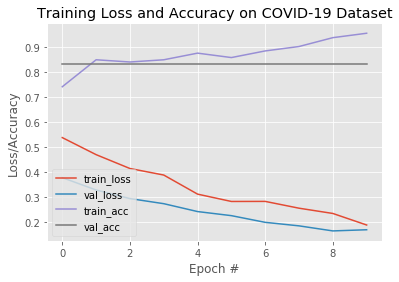

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

### Evaluation

In [20]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.84      1.00      0.91        26
      normal       0.00      0.00      0.00         5

    accuracy                           0.84        31
   macro avg       0.42      0.50      0.46        31
weighted avg       0.70      0.84      0.77        31



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion matrix

In [21]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[26  0]
 [ 5  0]]
acc: 0.8387
sensitivity: 1.0000
specificity: 0.0000


Now save the model

In [22]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('covid_model.h5') 

Test loaded model

In [23]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model('../input/model-out/covid_model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       0.90      1.00      0.95        26
      normal       1.00      0.40      0.57         5

    accuracy                           0.90        31
   macro avg       0.95      0.70      0.76        31
weighted avg       0.91      0.90      0.89        31



Test on covid image:

[[1.0000000e+00 1.4374905e-13]]
[0]


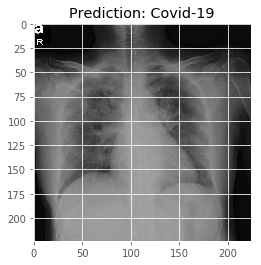

In [25]:
import numpy as np
from tensorflow.keras.preprocessing import image


#test_image = cv2.imread('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg')
#test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
#test_image = cv2.resize(test_image, (224, 224))
#test_image = np.expand_dims(test_image, axis = 0)

img_width, img_height = 224, 224
img = image.load_img('../input/covid-chest-xray/images/1-s2.0-S0929664620300449-gr2_lrg-a.jpg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1))
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)
plt.savefig('plot_out.png')

Test on normal image:

[[2.6846156e-11 1.0000000e+00]]
1


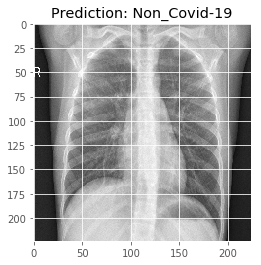

In [26]:
img_width, img_height = 224, 224
img = image.load_img('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0003-0001.jpeg', target_size = (img_width, img_height))
x = image.img_to_array(img)
img = np.expand_dims(x, axis = 0)

pred = new_model.predict(img)
print(pred)

#one = new_model.predict('../input/covid-chest-xray/images/1-s2.0-S1684118220300608-main.pdf-002.jpg', batch_size = BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
print(np.argmax(pred, axis=1)[0])
if np.argmax(pred, axis=1)[0] == 1:
    plt.title('Prediction: Non_Covid-19')
else:
    plt.title('Prediction: Covid-19')
plt.imshow(x/255.)

## Credits
This notebook is based on this tutorial - [link](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/)